### TASK: SECRET 3

### Approach:
We first load the data that is already set up in the repository or can be obtained using get_data.ipynb <br>
Following the suggestion in the task we used bz and dst to compute correlations and models <br>
* Correlation between the 2 variables: <br>
 * We computed covariance <br>
 * We computerd Pearson correlation <br>
* Model: <br>
 * Support vetor regreession (SVR) with nonlinear (RBF) kernel <br>

In [1]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from scipy.signal import correlate
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

### Load data

## stats; covariance and Pearson correlation

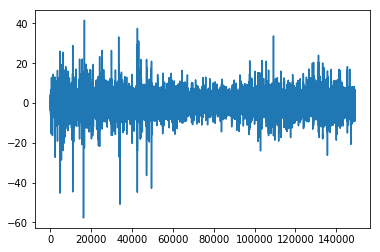

In [5]:
with open('./dst_yearly/alldata_2000-2016.txt', 'r') as fd: 
    dst = pickle.load(fd)

with open('./omni_bxe_bxm_hourly_averaged/alldata_2000-2016.txt') as fd:
    bz_e_m = pickle.load(fd)

signal_1 = [pair[2] for pair in bz_e_m]
signal_2 = [pair[1] for pair in dst]

plt.plot(signal_1)

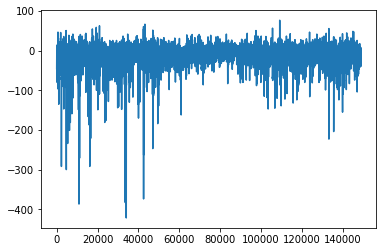

In [11]:
plt.plot(signal_2)

In [12]:
data = np.vstack((np.array(signal_1)[np.newaxis],np.array(signal_2)[np.newaxis]))
print "COVARIANCE"
print np.cov(data)
print "PEARSON CORRELATION"
print np.corrcoef(data)

COVARIANCE
[[   9.38780097   19.52207619]
 [  19.52207619  431.85933148]]
PEARSON CORRELATION
[[ 1.          0.30660054]
 [ 0.30660054  1.        ]]


## Results correlation
We computed Pearson correlation and covariance of the variables and based on the values we believe we can train a nonlinear regressor to fit the data well.

# Support Vector Regressor (SVR)
We trained a support vector regreesor and did a hyperparameter search over the window size of the past bz and dst values

In [250]:
past_feat = 2
start_train = 10
end_train = 5000

use_gt_history_as_feature = 2

X = np.array([signal_1[idx-past_feat:idx] for idx in range(start_train,end_train,1)])

if use_gt_history_as_feature != 0:
    X = np.hstack((X,[signal_2[idx-use_gt_history_as_feature-1:idx-1] for idx in range(start_train,end_train,1)]))

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)
X = (X - mean) / std
y = np.array(signal_2[start_train:end_train])
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1, verbose=True)#, max_iter=2500)
model = svr_rbf.fit(X, y)
y_rbf = model.predict(X)

[LibSVM]

In [251]:
print(np.shape(np.hstack((X,np.zeros((4990,1))))))
len(X)

(4990, 5)


4990

In [252]:
test_start_idx = end_train - 1000
test_end_idx = end_train + 50000
test_X = np.array([signal_1[idx-past_feat:idx] for idx in range(test_start_idx,test_end_idx,1)])
if use_gt_history_as_feature != 0:
    test_X = np.hstack((test_X,[signal_2[idx-use_gt_history_as_feature-1:idx-1] for idx in range(test_start_idx,test_end_idx,1)]))
test_X = ( test_X - mean ) / std
#test_y = model.predict(test_X)

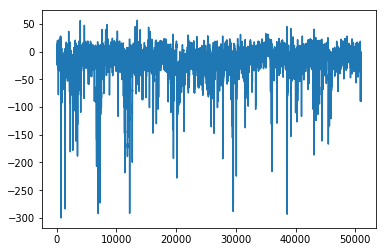

In [253]:
predictions = model.predict(test_X)
plt.plot(predictions)

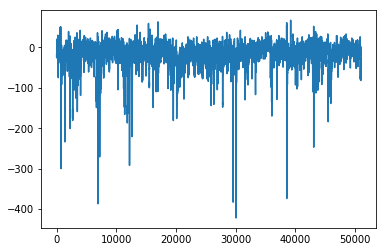

In [254]:
gt = signal_2[test_start_idx:test_end_idx]
plt.plot(gt)

In [255]:
mse = np.sum((predictions - gt)*(predictions - gt)) / len(predictions)

In [256]:
print(mse)

80.48472687446245


In [26]:
def train_SVR(past_size_bz, start_train, end_train, past_size_dst, test_start_idx, test_end_idx, C=1e3, gamma=0.1, verbose=False):
    """
    train SVR in a given setting

    Parameters
    ----------
    past_size_bz : int
        Size of past bz values to be used as features (including the one at the current moment)
    start_train : int 
        Index of the starting position in the dataset of the train subset
    end_train : int
        Index of the ending postion in the dataset of the train subset 
    past_size_dst : int
        Size of past dst values to be used as features (excluding the one at the current moment)
        0 means past dst values will not be used as features
    test_start_idx : int
        Index of the starting position in the dataset of the test subset
    test_end_idx : int 
        Index of the ending position in the dataset of the test subset
    C : float
        SVR parameter. Default C=1e3
    gamma : float
        SVR parameter. Default gamma=0.1
    verbose : boolean
        If True, we plot the predicted values of the testset and the ground truth

    Returns
    -------
    mse : int
        Mean Square Error of the prediction set vs the ground truth
    
    model : SVR
        A trained model
    """
    
    X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(start_train,end_train,1)])

    if past_size_dst != 0:
        X = np.hstack((X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(start_train,end_train,1)]))

    mean = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    
    X = (X - mean) / std
    
    #X = np.array(signal_1[0:1000]).reshape(-1,1)
    y = np.array(signal_2[start_train:end_train])
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    model = svr_rbf.fit(X, y)
    
    test_X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(test_start_idx,test_end_idx,1)])
    if past_size_dst != 0:
        test_X = np.hstack((test_X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(test_start_idx,test_end_idx,1)]))
    test_X = ( test_X - mean ) / std
    predictions = model.predict(test_X)
    gt = signal_2[test_start_idx:test_end_idx]
    mse = np.sum((predictions - gt)*(predictions - gt)) / len(predictions)
    
    if verbose == True:
        predictions = model.predict(test_X)
        plt.plot(predictions)
        gt = signal_2[test_start_idx:test_end_idx]
        plt.plot(gt)
    return mse, model

In [29]:
#past_size = 2
start_train = 10
end_train = 10000

#past_size_dst = 2
test_start_idx = end_train
test_end_idx = end_train + 50000

C=1e3
gamma=0.1

verbose=False

best_model = None
best_mse = 1000000

## VALIDATION and choosing hyperparameter
validation_history = []
for size1 in [1, 2, 4]:
    row = []
    for size2 in [0, 1, 2, 4]:
        mse, model = train_SVR(size1, start_train, end_train, size2, test_start_idx, test_end_idx, C, gamma, verbose)
        if mse < best_mse:
            best_mse = mse
            best_model = model
        row.append((size1, size2, mse))
        print(row[-1])
    validation_history.append(row)

(1, 0, 503.29976885716974)
(1, 1, 59.9999711739177)
(1, 2, 60.31759545245274)
(1, 4, 61.91428518713416)
(2, 0, 476.2184077514058)
(2, 1, 64.28513229853304)
(2, 2, 67.06041451407644)
(2, 4, 71.05059387361524)
(4, 0, 451.39102866111926)
(4, 1, 76.24835420897503)
(4, 2, 80.83495658748245)
(4, 4, 90.38362697716605)


Minimum_value:76.24835420897503
('best history len bz', 4)
('best history len dst', 1)


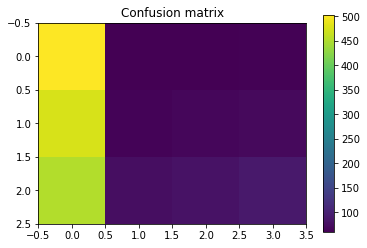

In [55]:
plt.imshow([[pair[2] for pair in row] for row in validation_history])
plt.colorbar()
plt.title('Confusion matrix')

print("Minimum_value:"+str(min_mse))
minimum_pair = None
for row in validation_history:
    for pair in row:
        if pair[2] < min_mse:
            minimum_pair = pair
print('best history len bz', minimum_pair[0])
print('best history len dst', minimum_pair[1])

# Train for longer with these parameters and test on unseen data

In [58]:
start_train = 10
end_train = 50000

test_start_idx = 50000 
test_end_idx = test_start_idx + 50000

C=1e3
gamma=0.1

verbose=False

mse, model = train_SVR(minimum_pair[0], start_train, end_train, minimum_pair[1], test_start_idx, test_end_idx, C, gamma, verbose)

In [63]:

print("MSE="+str(mse))
past_size_bz = minimum_pair[0]
past_size_dst = minimum_pair[1]
X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(start_train,end_train,1)])

if past_size_dst != 0:
    X = np.hstack((X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(start_train,end_train,1)]))

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

test_X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(test_start_idx,test_end_idx,1)])
if past_size_dst != 0:
    test_X = np.hstack((test_X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(test_start_idx,test_end_idx,1)]))
test_X = ( test_X - mean ) / std
predictions = model.predict(test_X)
gt = signal_2[test_start_idx:test_end_idx]
mse = np.sum((predictions - gt)*(predictions - gt)) / len(predictions)

MSE=17.63212199350689


Text(0.5,1,'prediction')

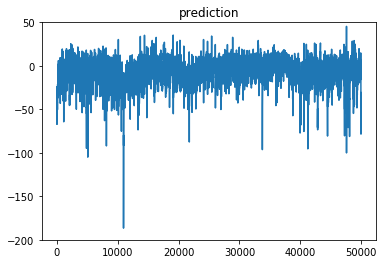

In [66]:
plt.plot(predictions)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-200,50))
plt.title("prediction")

Text(0.5,1,'Ground truth')

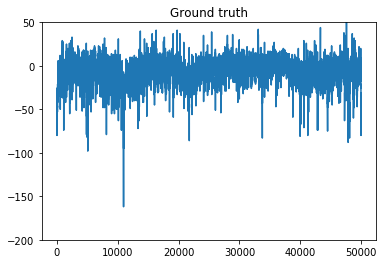

In [67]:
plt.plot(gt)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-200,50))
plt.title("Ground truth")

### Results SVR
At the moment we achieved visible progress and 17.63 MSE <br>
For this we used SVM for regression that takes as input at each timestep 4 previous bz values and 1 previous dst value

# RNN & LSTM 
We now see that we got nice results based on just these features but we want to see if we can do better than 17 Mean squared error by training a Neural Network, more specifically a Recurrent Neural Network, which specializes in time series data.

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# fit an LSTM network to training data
def train_lstm(X, y, epochs, neurons):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(1, 1, X.shape[2]), batch_size=1, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=epochs, batch_size=1, verbose=2, shuffle=False)
    
    return model

# make a prediction
def predict_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    pred = model.predict(X, batch_size=1)
    return pred[0,0]

In [10]:
past_size_bz = 4
start_train = 10
end_train = 10000

past_size_dst = 1
test_start_idx = end_train
test_end_idx = end_train + 50000


X = np.array([signal_1[idx-past_size_bz:idx] for idx in range(start_train,test_end_idx,1)])
if past_size_dst != 0:
    X = np.hstack((X,[signal_2[idx-past_size_dst-1:idx-1] for idx in range(start_train,test_end_idx,1)]))
y = np.array(signal_2[start_train:test_end_idx])

best_model = None
best_rmse = 100000

epochs_nr = 50

history_mse = []

for neurons in [32, 4, 1]:
    lstm_model = train_lstm(X[start_train:end_train], y[start_train:end_train], epochs_nr , neurons)

    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = X[start_train:end_train].reshape(X[start_train:end_train].shape[0], 1, X[start_train:end_train].shape[1])
    lstm_model.predict(train_reshaped,batch_size=1)


    # walk-forward validation on the test data
    predictions = list()
    raw_values = []
    for i in range(test_start_idx,test_end_idx-10,1):
        # make one-step forecast
        pred = predict_lstm(lstm_model, X[i])
        # store forecast
        predictions.append(pred)
        expected = y[i]
        raw_values.append(expected)
    
    # report performance
    rmse = np.sqrt(mean_squared_error(raw_values[:], predictions))
    print('Test RMSE: %.3f' % rmse)
    
    history_mse.append((neurons, rmse))
    if best_rmse > rmse:
        best_rmse = rmse
        best_model = lstm_model

Epoch 1/50
36s - loss: 379.7251
Epoch 2/50
32s - loss: 213.3964
Epoch 3/50
33s - loss: 164.0036
Epoch 4/50
34s - loss: 130.7593
Epoch 5/50
34s - loss: 124.8994
Epoch 6/50
34s - loss: 106.6905
Epoch 7/50
35s - loss: 105.6834
Epoch 8/50
35s - loss: 106.9363
Epoch 9/50
34s - loss: 106.7742
Epoch 10/50
34s - loss: 107.0980
Epoch 11/50
35s - loss: 93.7941
Epoch 12/50
33s - loss: 105.7625
Epoch 13/50
33s - loss: 105.8065
Epoch 14/50
33s - loss: 97.3288
Epoch 15/50
34s - loss: 89.3182
Epoch 16/50
36s - loss: 86.8165
Epoch 17/50
34s - loss: 78.8271
Epoch 18/50
34s - loss: 83.8833
Epoch 19/50
33s - loss: 86.2741
Epoch 20/50
32s - loss: 84.1656
Epoch 21/50
33s - loss: 83.0707
Epoch 22/50
33s - loss: 75.6555
Epoch 23/50
34s - loss: 79.7504
Epoch 24/50
33s - loss: 78.7509
Epoch 25/50
33s - loss: 76.4884
Epoch 26/50
33s - loss: 86.1183
Epoch 27/50
32s - loss: 79.3819
Epoch 28/50
33s - loss: 67.2370
Epoch 29/50
34s - loss: 66.9049
Epoch 30/50
35s - loss: 66.1245
Epoch 31/50
36s - loss: 64.2655
Epoch